In [1]:
import cv2
from PIL import Image
import imageio
from tqdm import tqdm

import torch
import torch.nn.init
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import json
import matplotlib

import matplotlib.pyplot as plt
import numpy as np
import time

import util
import NeuralNets as NN
import dataset



In [2]:
LEARNING_RATE =  0.001
EPOCHS = 64
BATCH_SIZE = 2

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)


In [4]:
TRAIN_PATH = "./third_train_data/img/"
LABEL_PATH = "./third_train_data/label.json"

class FocusDataset2(Dataset):
    def __init__(self, path, label_path, transform=None):
        self.x_datas = []
        self.y_datas = {}
        self.path = path
        self.transform = transform

        fileDir = os.listdir(path)
        for file in fileDir:
            self.x_datas.append(file)
        
        file = open(label_path, 'r')
        c = json.load(file)
        for each in c:
            self.y_datas[each["img_path"]] = each["focus_point"]
        self.x_datas = self.x_datas[:40]
    def __len__(self):
        return len(self.x_datas)

    def __getitem__(self, idx):
        target = self.x_datas[idx]
        
        x = Image.open(self.path + target).convert("RGB")

        y = np.array(self.y_datas[target])
        y = dataset.makeHeatmap((NN.INPUT_SHAPE[1]//2, NN.INPUT_SHAPE[0]//2), y//2)
        
        if self.transform:
            x = util.transform(x, y)

        x = x.resize(NN.INPUT_SHAPE)
        x = np.array(x)
        
        return x , y[..., None]
        
trainDataset = FocusDataset2(TRAIN_PATH, LABEL_PATH)
train_loader =  DataLoader(dataset = trainDataset, batch_size=BATCH_SIZE, shuffle=True )

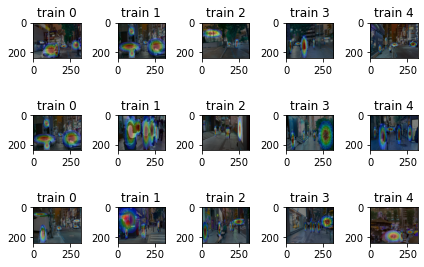

In [5]:
import random

fig, ax = plt.subplots(3, 5)


for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]


    focus = trainData[1]
    img = trainData[0]

    heatImg = util.cvt2Heatmap(focus, img)

    ax[0, i].imshow(heatImg)
    ax[0, i].set_title("train {}".format(i))

for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]

    img = trainData[0]
    focus = trainData[1]

    heatImg = util.cvt2Heatmap(focus, img)

    ax[1, i].imshow(heatImg)
    ax[1, i].set_title("train {}".format(i))

for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]

    img = trainData[0]
    focus = trainData[1]

    heatImg = util.cvt2Heatmap(focus, img)

    ax[2, i].imshow(heatImg)
    ax[2, i].set_title("train {}".format(i))

plt.tight_layout()
plt.show()

In [6]:
model = NN.FocusNN3()
model = torch.nn.DataParallel(model)
model.to(device)

criterion = torch.nn.MSELoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print(model)

import torchsummary
torchsummary.torchsummary.summary(model, batch_size=BATCH_SIZE,device=device,input_size=(3, 480, 640))


DataParallel(
  (module): FocusNN3(
    (reduce_features): ModuleList(
      (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Bottleneck(
        (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentu

C:\Users\yunmi\anaconda3\envs\torch-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch: 1 	Training Loss: 0.01628


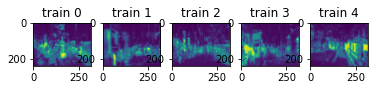

Epoch: 2:  15%|█▌        | 3/20 [00:05<00:29,  1.75s/it]


KeyboardInterrupt: 

In [10]:
# TRAIN MODEL
train_losses = []

for singleEpoch in range(1, EPOCHS+1):
    startTime = time.time()

    train_loss = 0.0
    total = 0
    model.train()

    tmp = None
    for data, points in tqdm(train_loader, desc="Epoch: {}".format(singleEpoch)):
        data = data.permute(0, 3, 1, 2)
        data = data.cuda().float()
        
        points = points.cuda().float()

        # cleaer the gradients all optimized variables
        optimizer.zero_grad()

        # forward process
        out = model(data)[0]

        # backpropagation
        loss = criterion(out, points)
        loss.backward()

        optimizer.step()
        total += BATCH_SIZE
        train_loss += loss.item()
    # calculate average loss
    train_loss = train_loss/total
    train_losses.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.5f}'.format(singleEpoch, train_loss))

    fig, ax = plt.subplots(1, 5)


    for i in range(5):
        randId = int(random.random() * len(trainDataset))
        trainData = trainDataset[randId]

        img = trainData[0] 
        data = torch.tensor(img)
        data = data.permute(2, 0, 1)[None,...]
        data = data.to(device, non_blocking=True).long().float()
        predictions = model(data)[0].cpu().detach().numpy()[0]
        heatImg = (np.clip(0, 1, predictions)*255).astype(np.uint8)

        ax[i].imshow(heatImg)
        ax[i].set_title("train {}".format(i))

    plt.show()

In [ ]:
torch.save(model.state_dict(), "./weights/model_focus3_1.ckpt")

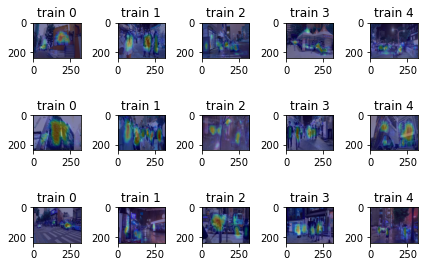

In [ ]:
fig, ax = plt.subplots(3, 5)


for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]
    img = trainData[0]


    data = torch.tensor(img)
    data = data.permute(2, 0, 1)[None,...]
    data = data.to(device, non_blocking=True).long().float()
    predictions = model(data)[0].cpu().detach().numpy()[0]
    

    heatImg = util.cvt2Heatmap(predictions, img)

    ax[0, i].imshow(heatImg)
    ax[0, i].set_title("train {}".format(i))

for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]

    img = trainData[0]
    data = torch.tensor(img)
    data = data.permute(2, 0, 1)[None,...]
    data = data.to(device, non_blocking=True).long().float()
    predictions = model(data)[0].cpu().detach().numpy()[0]
    

    heatImg = util.cvt2Heatmap(predictions, img)

    ax[1, i].imshow(heatImg)
    ax[1, i].set_title("train {}".format(i))

for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]

    img = trainData[0]
    
    data = torch.tensor(img)
    data = data.permute(2, 0, 1)[None,...]
    data = data.to(device, non_blocking=True).long().float()
    predictions = model(data)[0].cpu().detach().numpy()[0]
    

    heatImg = util.cvt2Heatmap(predictions, img)

    ax[2, i].imshow(heatImg)
    ax[2, i].set_title("train {}".format(i))

plt.tight_layout()
plt.show()